# Classification of Buddhist Scriptures Using Unsupervised Models of Frequency and Sentiment
## Introduction
### Problem Statement
Buddhism is one of the world's major religions. Its primary branches are Theravada, Mahayana, and Vajrayana. These branches can be distinguished by, among many other features, which scriptures they accept as legitimate. Theravada is the most conservative in this respect, accepting the smallest set of scriptures. Mahayana accepts a larger set of scriptures. Vajrayana is the most liberal, accepting all of the scriptures of the Theravada, Mahayana, and an additional set unique to Vajrayana.
Historians of religion, and religious practitioners, debate the historical origins of these branches and frequently when new texts are discovered by archaeologists, there is a question as to which branch these text belong. Machine learning methods can help us to categorize these texts in a way that may avoid both the possible sectarian divisions of practitioners and the possibly mistaken assumptions of historians.
Thus, this project seeks to use unsupervised machine learning methods to categorize a group of texts as either Theravada, Mahayana, or Vajrayana.

### Data
I have collected excerpts from texts associated with each branch, saved as theravada-excerpts.txt, mahayana-excerpts.txt, and vajrayana-excerpts.txt. These excerpts are taken from scriptures that are taken by domain excerpts to be representative of the textual tradition of each branch. For each branch, the excerpts are taken from four separate texts in chunks of about 200 lines. 

## Preprocessing
First, I've loaded in the texts below and gotten a word count. We can see that there are a roughly equal number of words  (~5000) in each of the sets of excerpts. This is what we want for modeling purposes.

In [38]:
with open('theravada-excerpts.txt', 'r') as excerpts:
    theravada = excerpts.read().split(' ')

print('Theravada Excerpts Word Count:' + str(len(theravada)))

with open('mahayana-excerpts.txt', 'r') as excerpts:
    mahayana = excerpts.read().split(' ')

print('Mahayana Excerpts Word Count:' + str(len(mahayana)))

with open('vajrayana-excerpts.txt', 'r') as excerpts:
    vajrayana = excerpts.read().split(' ')

print('Vajrayana Excerpts Word Count:' + str(len(vajrayana)))

Theravada Excerpts Word Count:5094
Mahayana Excerpts Word Count:4885
Vajrayana Excerpts Word Count:4863


Next, I'll split the sets of excerpts into chunks of 200 words to act as the samples in our data. 

In [39]:
theravada_chunks = []
mahayana_chunks = []
vajrayana_chunks = []

for i in range(0,len(theravada) - 199, 200):
    theravada_chunks.append(' '.join(theravada[i:i+199]))

for i in range(0,len(mahayana) - 199, 200):
    mahayana_chunks.append(' '.join(mahayana[i:i+199]))

for i in range(0,len(vajrayana) - 199, 200):
    vajrayana_chunks.append(' '.join(vajrayana[i:i+199]))

We can now construct our initial dataframe of text excerpts and category labels. I will use 0 for Theravada, 1 for Mahayana, and 2 for Vajrayana.

In [40]:
import pandas as pd

In [41]:
th_data = {'text':theravada_chunks, 'branch': [0]*(len(theravada_chunks))}
th_df = pd.DataFrame(th_data)

ma_data = {'text': mahayana_chunks, 'branch': [1]*(len(mahayana_chunks))}
ma_df = pd.DataFrame(ma_data)

va_data = {'text':vajrayana_chunks, 'branch': [2]*(len(vajrayana_chunks))}
va_df = pd.DataFrame(va_data)

df = pd.concat([th_df, ma_df, va_df])

df = df.sample(frac=1).reset_index(drop=True)

df.head()

,text,branch
0,illusion is accomplished without exclusion or ...,2
1,"all the above categories.\nThere are naked, ve...",2
2,cut off from life. Please do not think in that...,1
3,"the sensed, he conceives [himself as] the sens...",0
4,"Subhuti, what the Buddha calls a self essentia...",1


## Quantifying the Text
Now that we have a dataframe of our text, we can start turning it into something quantifiable for modeling. I will use two approaches here. The first is the frequency analysis that we are already familiar with. The second is sentiment analysis.

### Frequency Analysis

Below, I have used TfidVectorizer to get the word frequencies out of the set of texts. 

Because the texts sometimes use jargon drawn from Pali, Sanksrit, and Tibetan, the text is not necessarily friendly to process. To accomodate this, I have set decode_error to 'ignore'. This will tell the vectorizer to ignore any characters that it can not parse at all. I have also set strip_accents to 'unicode', so that the accent marks that are common in these languages can be more easily handled.

Because it is a small data set and performance is not a big concern, I have limited max_features to 20 and set the n-gram range to (1,5). The n-gram range will thus look for the frequencies of single words as well as phrases of up to 5 words.

Finally, I have set sublinear_tf to True. This tells the vectorizer to return the log value of the frequencies. This is to accomodate Zipf's Law which tells us that word frequency is exponential. Making this change should make our modeling a little more reliable, without unduly weighting anything. 

I then simplify this frequency matrix using Truncated Singular Value Decomposition, to reduce the number of dimensions to 5.

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [43]:
freq_matrix = TfidfVectorizer(decode_error='ignore', strip_accents='unicode',max_features=20, ngram_range=(1,5), sublinear_tf=True).fit_transform(df['text']).toarray()

In [44]:
tsvd = TruncatedSVD(n_components=5).fit_transform(freq_matrix)

In [45]:
tsvd_feature_list = []
for i in range(5):
    name =('tsvd_' + str(i))
    tsvd_feature_list.append(name)
    df[name] = [el[i] for el in tsvd.tolist()]

#### Frequency Clustering Visualization
We can see in the visualization below, that even just looking at the two dimensional reduced matrix, there is a noticeable degree of clustering happening in our data.

In [46]:
import seaborn as sns

<AxesSubplot:xlabel='tsvd_0', ylabel='tsvd_1'>

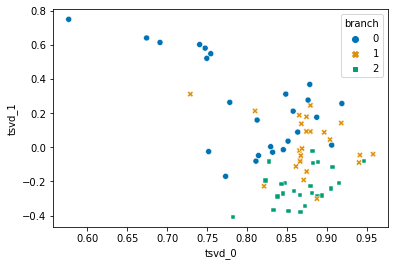

In [47]:
sns.scatterplot(
    data=df,
    x= 'tsvd_0',
    y= 'tsvd_1',
    hue='branch',
    palette='colorblind',
    style='branch'
)

### Sentiment Analysis

Now that frequency analysis is complete, I'll perform the Sentiment Analysis. Below, I have processed the texts using SentimentIntensityAnalyzer from the nltk python library. The SIA returns for each text a dictionary of scores: 'neg' representing how negative the text is; 'pos' representing how positive the text is; 'neu' representing how neutral the text is; and 'compound' which is compound score which summarizes the other three. These scores are assigned based on a lexicon of pre-designated positive, negative, and neutral words. Here I have used the 'vader' lexicon that nltk provides.

In [48]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /home/j/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [49]:
sentiments = []
sia = SentimentIntensityAnalyzer()
for text in df['text']:
    sentiment = sia.polarity_scores(text)
    sentiments.append(sentiment)

sent_df = pd.DataFrame(sentiments)

df['neg'] = sent_df['neg']
df['pos'] = sent_df['pos']
df['neu'] = sent_df['neu']
df['compound'] = sent_df['compound']

I've append both the reduced matrix and the sentiment scores to the data frame now and we can see this below.

In [50]:
df.head()

,text,branch,tsvd_0,tsvd_1,tsvd_2,tsvd_3,tsvd_4,neg,pos,neu,compound
0,illusion is accomplished without exclusion or ...,2,0.882288,-0.093668,-0.253582,-0.003593,0.138440,0.037,0.095,0.868,0.9178
1,"all the above categories.\nThere are naked, ve...",2,0.879364,-0.226696,0.265785,0.169445,-0.037227,0.068,0.080,0.852,0.6249
2,cut off from life. Please do not think in that...,1,0.867944,0.137929,0.203291,0.192516,-0.176119,0.061,0.120,0.819,0.9059
3,"the sensed, he conceives [himself as] the sens...",0,0.691123,0.614212,-0.100098,0.230946,-0.083002,0.000,0.057,0.943,0.9179
4,"Subhuti, what the Buddha calls a self essentia...",1,0.879290,0.245531,0.026291,0.005957,-0.277221,0.042,0.095,0.863,0.9278


#### Sentiment Visualization

Below, I've plotted the compound sentiment scores for each branch as a boxplot. We can see that the median scores are similar. 1 is the most positive score here so it seems like all of our texts are pretty positive. That bodes well for a religious scripture. We can see that the Theravada (0) branch does seem to skew much more negative, at least in this sample.

<AxesSubplot:xlabel='branch', ylabel='compound'>

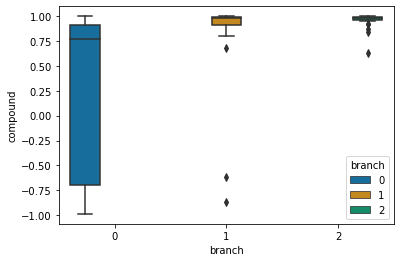

In [51]:
sns.boxplot(
    data=df,
    x='branch',
    y='compound',
    hue='branch',
    palette='colorblind',
)


Below, I've plotted a scatterplot with the positive sentiment score on the x-axis and the negative sentiment score on the y-axis. The clusters here are less obvious than in the frequency plot or in the compound sentiment boxplot above, but not entirely absent.

<AxesSubplot:xlabel='pos', ylabel='neg'>

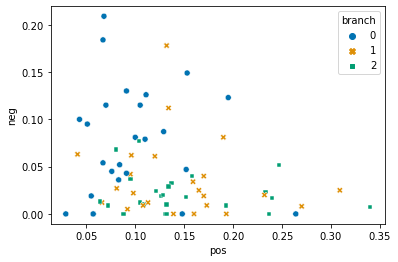

In [52]:
sns.scatterplot(
    data=df,
    x= 'pos',
    y= 'neg',
    hue='branch',
    palette='colorblind',
    style='branch'
)

## Modeling

### Unsupervised Models
#### First Pass Models

Below, I have trained a series of models. First, I've trained a series of models using the frequency data with each model increasing the number of components used. I've performed this portion for both the KMeans algorithm and the Agglomerative Clustering Algorithm.

Next, I trained a series of models using the sentiment analysis data using the compound score alone, the positive and negative scores, and all four: positive, negative, neutral, and compound scores.

In [53]:
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import accuracy_score, confusion_matrix

In this cell, I've adapted the code that I wrote for the assignment in a previous model to help with interpreting category labels.

In [54]:
def label_permute_compare(ytdf,yp):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (1, 2, 0), 0.74  
    """
# your code here
    labels = [0,1,2]
    best = -1
    best_labels = None
    
    for n in range(3):
    
        for i in range(len(labels)):
            labels[i] += 1
            labels[i] = labels[i] % 3
            
    
        y_true = ytdf['branch'].replace({0 : labels[0], 1 : labels[1], 2 : labels[2]})
        score = accuracy_score(y_true, yp)
        
        if score >= best:
                best = score
                best_labels = labels
                
    return best_labels, best

In [75]:
k_avg = np.zeros(len(tsvd_feature_list) + 1)
agg_avg = np.zeros(len(tsvd_feature_list) + 1)

iterations = 100

for j in range(iterations):
    for i in range(len(tsvd_feature_list)+1):

        kmeans = KMeans(n_clusters=3, n_init='auto').fit(df[:len(df)//2][tsvd_feature_list[:i+1]])

        agg_preds = AgglomerativeClustering(n_clusters=3).fit_predict(df[tsvd_feature_list[:i+1]])

        k_preds = kmeans.predict(df[len(df)//2:][tsvd_feature_list[:i+1]])

        k_acc = label_permute_compare(df[len(df)//2:],k_preds)[1]

        k_avg[i] = k_avg[i] + k_acc

        agg_acc = label_permute_compare(df,agg_preds)[1]

        agg_avg[i] = agg_avg[i] + agg_acc

for i in range(len(k_avg)):
    k_avg[i] = k_avg[i] / iterations
    agg_avg[i] = agg_avg[i] / iterations

##### Frequency Model Results
We can see below that the KMeans algorithm (in blue) performs substantially better than the Agglomerative Clustering model (in dotted orange)  at any number of components. Interestingly, the Agglomerative Clustering model spikes at two components, while the KMeans model trends more generall upward as more components are added.

<AxesSubplot:>

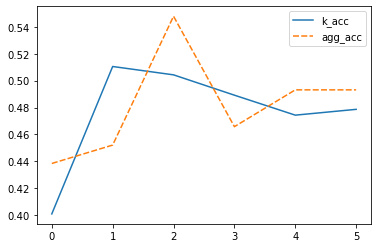

In [76]:
results = {'n_comp':list(range(1,len(tsvd_feature_list) + 2,1)), 'k_acc': k_avg, 'agg_acc': agg_avg}
result_df = pd.DataFrame(data=results)

sns.lineplot(data=result_df[['k_acc', 'agg_acc']])

In [78]:
k_avg_acc = 0
agg_avg_acc = 0

iterations = 100

# train with compound score

for j in range(iterations):

    kmeans = KMeans(n_clusters=3, n_init='auto').fit(df[:len(df)//2][['compound']])
    agg_preds = AgglomerativeClustering(n_clusters=3).fit_predict(df[['compound']])
    k_preds = kmeans.predict(df[len(df)//2:][['compound']])
    k_acc = label_permute_compare(df[len(df)//2:],k_preds)[1]
    k_avg_acc = k_avg_acc + k_acc
    agg_acc = label_permute_compare(df,agg_preds)[1]
    agg_avg_acc = agg_avg_acc + agg_acc

com_k_avg_acc = k_avg_acc / iterations
com_agg_avg_acc = agg_avg_acc / iterations

# train with pos and neg

k_avg_acc = 0
agg_avg_acc = 0

for j in range(iterations):

    kmeans = KMeans(n_clusters=3, n_init='auto').fit(df[:len(df)//2][['pos', 'neg']])
    agg_preds = AgglomerativeClustering(n_clusters=3).fit_predict(df[['pos', 'neg']])
    k_preds = kmeans.predict(df[len(df)//2:][['pos', 'neg']])
    k_acc = label_permute_compare(df[len(df)//2:],k_preds)[1]
    k_avg_acc = k_avg_acc + k_acc
    agg_acc = label_permute_compare(df,agg_preds)[1]
    agg_avg_acc = agg_avg_acc + agg_acc

pos_neg_k_avg_acc = k_avg_acc / iterations
pos_neg_agg_avg_acc = agg_avg_acc / iterations

# train with all

k_avg_acc = 0
agg_avg_acc = 0

for j in range(iterations):

    kmeans = KMeans(n_clusters=3, n_init='auto').fit(df[:len(df)//2][['pos', 'neg', 'neu', 'compound']])
    agg_preds = AgglomerativeClustering(n_clusters=3).fit_predict(df[['pos', 'neg', 'neu', 'compound']])
    k_preds = kmeans.predict(df[len(df)//2:][['pos', 'neg', 'neu', 'compound']])
    k_acc = label_permute_compare(df[len(df)//2:],k_preds)[1]
    k_avg_acc = k_avg_acc + k_acc
    agg_acc = label_permute_compare(df,agg_preds)[1]
    agg_avg_acc = agg_avg_acc + agg_acc

all_k_avg_acc = k_avg_acc / iterations
all_agg_avg_acc = agg_avg_acc / iterations

##### Sentiment Results
From the results below, we can see that the KMeans model outperforms the Agglomerative Clustering model in all cases. The best performing model is the model that uses the positive and negative sentiment scores. This is perhaps not too surprising from a statistical perspective. None of the scores are truly independent of one another. Adding additional variables that are not independent only makes statistical modeling less reliable, in general.

In [79]:
print('Average accuracy of KMeans model using only the compound sentiment score:' + str(round(com_k_avg_acc, 3)))
print('Average accuracy of Agglomerative Clustering model using only the compound sentiment score:' + str(round(com_agg_avg_acc, 3)) + '\n')

print('Average accuracy of KMeans model using positive and negative sentiment scores:' + str(round(pos_neg_k_avg_acc, 3)))
print('Average accuracy of Agglomerative Clustering model using positive and negative sentiment scores:' + str(round(pos_neg_agg_avg_acc, 3)) + '\n')

print('Average accuracy of KMeans model using all sentiment scores:' + str(round(all_k_avg_acc, 3)))
print('Average accuracy of Agglomerative Clustering model using all sentiment scores:' + str(round(all_agg_avg_acc, 3)) + '\n')

Average accuracy of KMeans model using only the compound sentiment score:0.434
Average accuracy of Agglomerative Clustering model using only the compound sentiment score:0.425

Average accuracy of KMeans model using positive and negative sentiment scores:0.443
Average accuracy of Agglomerative Clustering model using positive and negative sentiment scores:0.466

Average accuracy of KMeans model using all sentiment scores:0.436
Average accuracy of Agglomerative Clustering model using all sentiment scores:0.438



#### Iterating on the Best Models

We saw above that the best models are trained using the Agglomerative Clustering algorithm using two components of the TSVD matrix, a KMeans model using 4 components of the TSVD matrix, or a KMeans model using the positive and negative sentiment scores. Below, I've trained two sets of 100 models models in isolation using just these two approaches and found their average accuracies. We can see that the accuracies are similar, though the sentiment based model performs slightly better.

In [59]:
iterations = 100

f_agg_acc = 0
s_k_acc = 0
f_k_acc = 0

for i in range(iterations):
    # agg frequency model
    f_agg_preds = AgglomerativeClustering(n_clusters=3).fit_predict(df[tsvd_feature_list[:2]])
    f_agg_acc += label_permute_compare(df,f_agg_preds)[1]

    # km frequency model
    f_kmeans = KMeans(n_clusters=3, n_init='auto').fit(df[:len(df)//2][tsvd_feature_list[:4]])
    f_k_preds = f_kmeans.predict(df[len(df)//2:][tsvd_feature_list[:4]])
    f_k_acc += label_permute_compare(df[len(df)//2:],f_k_preds)[1]

    # sentiment model
    s_kmeans = KMeans(n_clusters=3, n_init='auto').fit(df[:len(df)//2][['pos','neg']])
    s_k_preds = s_kmeans.predict(df[len(df)//2:][['pos','neg']])
    s_k_acc += label_permute_compare(df[len(df)//2:],s_k_preds)[1]

f_agg_acc = f_agg_acc / iterations
f_k_acc = f_k_acc / iterations
s_k_acc = s_k_acc / iterations

print("Average Frequency Agglomerative Clustering Model Accuracy: " + str(round(f_agg_acc, 3)))

print("Average Frequency KMeans Model Accuracy: " + str(round(f_k_acc, 3)))

print("Average Sentiment KMeans Model Accuracy: " + str(round(s_k_acc, 3)))

Average Frequency Agglomerative Clustering Model Accuracy: 0.452
Average Frequency KMeans Model Accuracy: 0.471
Average Sentiment KMeans Model Accuracy: 0.441


##### Combined Model
Below, I've trained an additional series of models that use both the TSVD matrix and the positive and negative sentiment score. I've trained both a KMeans model which draws from the first five elements of the TSVD matrix and an Agglomerative Clustering model that uses only the first element of the TSVD matrix. Below, we see that the Agglomerative Clustering model is still not performing as well as the KMeans version. The KMeans model with both the frequencies and the sentiments appears to perform comparably to the individual models but my suspicion is that we can improve these results with some tuning of the hyperparameters.

In [60]:
iterations = 100

c_k_acc = 0
c_agg_acc = 0


for i in range(iterations):
    # kmeans model
    c_kmeans = KMeans(n_clusters=3, n_init='auto').fit(df[:len(df)//2][tsvd_feature_list[:4]+['pos','neg']])
    c_k_preds = c_kmeans.predict(df[len(df)//2:][tsvd_feature_list[:4]+['pos','neg']])
    c_k_acc += label_permute_compare(df[len(df)//2:],c_k_preds)[1]

    # agg model
    c_agg_preds = AgglomerativeClustering(n_clusters=3).fit_predict(df[tsvd_feature_list[:2] + ['pos', 'neg']])
    c_agg_acc += label_permute_compare(df,c_agg_preds)[1]

c_k_acc = c_k_acc / iterations
c_agg_acc = c_agg_acc / iterations

print("Averaged Combined KMeans Model Accuracy: " + str(round(c_k_acc, 3)))
print("Averaged Combined Agglomerative Model Accuracy: " + str(round(c_agg_acc, 3)))

Averaged Combined KMeans Model Accuracy: 0.479
Averaged Combined Agglomerative Model Accuracy: 0.452


##### Hyperparameter Tuning the Combined Model
So we have an optimal approach: a KMeans model using four components of the TSVD matrix and the positive and negative sentiment scores. Let's tune the hyperparameters to ensure that this model is as optimized as it can be.

The most important hyperparameter for KMeans Clustering for our purposes is which algorithm is used to solve. By default the sklearn library uses the Lloyd algorith. The alternative is the Elkan algorithm.

The other important hyperparameters are the maximum number of iterations the algorithm will run (max_iter = 300 by default), and the number of the times the algorithm runs with different centroid "seeds", randomly chosen initial centroids (n_init = 10 by default).

Below I've begun by exploring the effects of these less interesting hyperparameters before moving into the more impactful algorithm hyperparameter.

##### n_init

First up is n_init values. We can see below that accuracy is maximized when n_init is set to 10.

<AxesSubplot:xlabel='n_init', ylabel='acc'>

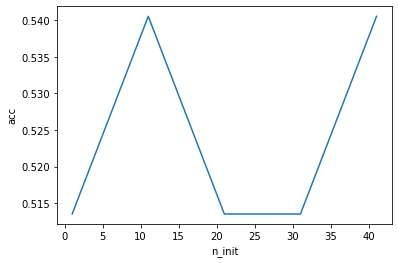

In [61]:
# experimenting with init values

inits = 50

ht_accs = []

for i in range(1, inits, 10):
    ht_mod = KMeans(n_clusters=3, n_init = i).fit(df[:len(df)//2][tsvd_feature_list[:4]+['pos','neg']])
    ht_preds = ht_mod.predict(df[len(df)//2:][tsvd_feature_list[:4]+['pos','neg']])
    ht_accs.append(label_permute_compare(df[len(df)//2:], ht_preds)[1])


results = {'n_init':list(range(1,50,10)), 'acc': ht_accs}
result_df = pd.DataFrame(data=results)

sns.lineplot(data=result_df, x='n_init', y='acc')

##### max_iter
Next, let's see what effect the max_iter hyperparameter has on our accuracy. Below I've trained a series of models with different values of max_iter and graphed the results. We can see that the default value of 300 is actually a local minimum of accuracy. We would be better off going either higher or lower. For performance reasons we may prefer the lower number but since our data set here is quite small, I'll move forward the higher value of 400 iterations.

<AxesSubplot:xlabel='max_iters', ylabel='acc'>

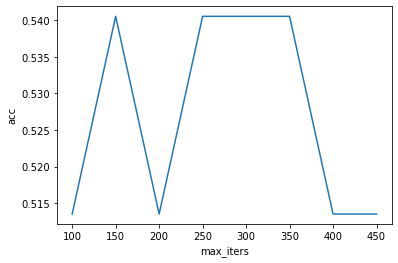

In [81]:
# experimenting with max_iter values

iters = 500

ht_accs = []

for i in range(100, iters, 50):
    ht_mod = KMeans(n_clusters=3, n_init=10,max_iter=iters).fit(df[:len(df)//2][tsvd_feature_list[:4]+['pos','neg']])
    ht_preds = ht_mod.predict(df[len(df)//2:][tsvd_feature_list[:4]+['pos','neg']])
    ht_accs.append(label_permute_compare(df[len(df)//2:], ht_preds)[1])


results = {'max_iters':list(range(100,500,50)), 'acc': ht_accs}
result_df = pd.DataFrame(data=results)

sns.lineplot(data=result_df, x='max_iters', y='acc')

##### Algorithm Selection
Now, with n_init set to 10 and max_iter set to 400 we can test the accuracy of the two different algorithm choices: Lloyd and Elkan. I've trained two sets of models below, one set with Lloyd and then other using the Elkan algorith. I've trained 500 models each and saved their accuracies.

In [63]:
l_ht_accs = []
e_ht_accs = []

for i in range(500):
    # lloyd model
    l_ht_mod = KMeans(n_clusters=3, n_init=10,max_iter=400, algorithm='lloyd').fit(df[:len(df)//2][tsvd_feature_list[:4]+['pos','neg']])
    l_ht_preds = l_ht_mod.predict(df[len(df)//2:][tsvd_feature_list[:4]+['pos','neg']])
    l_ht_accs.append(label_permute_compare(df[len(df)//2:], l_ht_preds)[1])

    # elkan model
    e_ht_mod = KMeans(n_clusters=3, n_init=10,max_iter=400, algorithm='elkan').fit(df[:len(df)//2][tsvd_feature_list[:4]+['pos','neg']])
    e_ht_preds = e_ht_mod.predict(df[len(df)//2:][tsvd_feature_list[:4]+['pos','neg']])
    e_ht_accs.append(label_permute_compare(df[len(df)//2:], e_ht_preds)[1])

I've printed the average accuracies below as well as a box plot of acccuracies. We can see that the average accuracy (either mean or median) does not differ subtantially and the range of accuracy is also nearly identical.

Mean Lloyd Accuracy: 0.525
Mean Elkan Accuracy: 0.525

Median Lloyd Accuracy: 0.514
Median Elkan Accuracy: 0.514


<AxesSubplot:>

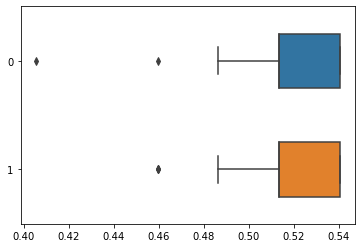

In [64]:
ht_dict = {'lloyd': l_ht_accs, 'elkan': e_ht_accs}
ht_df = pd.DataFrame(ht_dict)

print("Mean Lloyd Accuracy: " + str(round(np.mean(l_ht_accs),3)))
print("Mean Elkan Accuracy: " + str(round(np.mean(e_ht_accs),3)) + '\n')

print("Median Lloyd Accuracy: " + str(round(np.median(l_ht_accs),3)))
print("Median Elkan Accuracy: " + str(round(np.median(e_ht_accs),3)))


sns.boxplot(
    data= [l_ht_accs, e_ht_accs],
    orient='h',
    width = .5,
)

#### Final Unsupervised Model

So, we have a final model. This is a KMeans model using four components of the TSVD matrix and the positive and negative sentiment scores. The hyperparameters are n_init = 10, max_iter = 400, and algorith, finding no substantial difference between the two options, we will leave as the default: Lloyd.

Let's take a look at some of the features of this model. I've trained a fresh single model below.

In [86]:
fin_mod = KMeans(n_clusters=3, n_init=10,max_iter=400, algorithm='lloyd').fit(df[:len(df)//2][tsvd_feature_list[:4]+['pos','neg']])
fin_preds = fin_mod.predict(df[len(df)//2:][tsvd_feature_list[:4]+['pos','neg']])
fin_acc = label_permute_compare(df[len(df)//2:], fin_preds)[1]

print("Accuracy of single iteration of final model: " + str(round(fin_acc,3)))

Accuracy of single iteration of final model: 0.541


##### Visualizing the Final Model

The accuracy is nothing to be excited about, so let's explore the clustering that the model is performing. Below, I've appended the predicted labels to our original data frame. Note that these labels are not necessarily the same labels as I originally assigned. For example, the model may be assigning Theravada to 1 rather than 0. That's ok for now, we just want to see what the cluster it's finding look like compared to our original visualizations.

In [66]:
df['pred'] = fin_mod.predict(df[tsvd_feature_list[:4]+['pos','neg']])

df.head()

,text,branch,tsvd_0,tsvd_1,tsvd_2,tsvd_3,tsvd_4,neg,pos,neu,compound,pred
0,illusion is accomplished without exclusion or ...,2,0.882288,-0.093668,-0.253582,-0.003593,0.138440,0.037,0.095,0.868,0.9178,1
1,"all the above categories.\nThere are naked, ve...",2,0.879364,-0.226696,0.265785,0.169445,-0.037227,0.068,0.080,0.852,0.6249,1
2,cut off from life. Please do not think in that...,1,0.867944,0.137929,0.203291,0.192516,-0.176119,0.061,0.120,0.819,0.9059,0
3,"the sensed, he conceives [himself as] the sens...",0,0.691123,0.614212,-0.100098,0.230946,-0.083002,0.000,0.057,0.943,0.9179,2
4,"Subhuti, what the Buddha calls a self essentia...",1,0.879290,0.245531,0.026291,0.005957,-0.277221,0.042,0.095,0.863,0.9278,0


Recall that this is the true distribution of labels using the first two components of the TSVD matrix.

<AxesSubplot:xlabel='tsvd_0', ylabel='tsvd_1'>

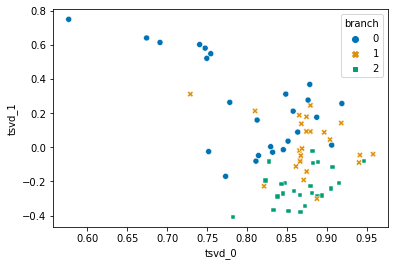

In [67]:
sns.scatterplot(
    data=df,
    x= 'tsvd_0',
    y= 'tsvd_1',
    hue='branch',
    palette='colorblind',
    style='branch'
)

And here is what our model predicts.

<AxesSubplot:xlabel='tsvd_0', ylabel='tsvd_1'>

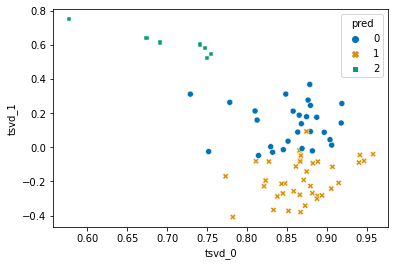

In [68]:
sns.scatterplot(
    data=df,
    x= 'tsvd_0',
    y= 'tsvd_1',
    hue='pred',
    palette='colorblind',
    style='pred'
)

Visually, we're not that far off. Let's look at the sentiment scores. Again, here is the original scatter plot using positive and negative sentiments with the true labels.

<AxesSubplot:xlabel='pos', ylabel='neg'>

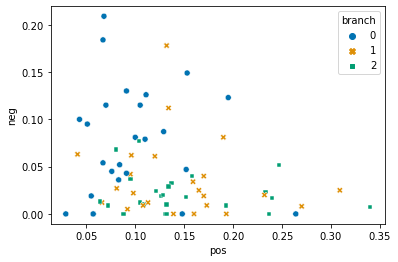

In [69]:
sns.scatterplot(
    data=df,
    x= 'pos',
    y= 'neg',
    hue='branch',
    palette='colorblind',
    style='branch'
)

And here's that graph using the predictions from our model. We're definitely in the ball park though not as accurate as we might like.

<AxesSubplot:xlabel='pos', ylabel='neg'>

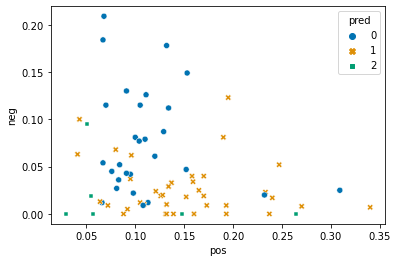

In [70]:
sns.scatterplot(
    data=df,
    x= 'pos',
    y= 'neg',
    hue='pred',
    palette='colorblind',
    style='pred'
)

### Supervised Models

#### Baseline Model
Let's take a look now at supervised models. Below, I've trained a supervised K-Nearest Neighbors model on our data set. I've chosen K-Nearest Neighbors for its conceptual similarity to the clustering algorithms we used in the Unsupervised section. 

In [71]:
from sklearn.neighbors import KNeighborsClassifier

We can see below that there is an immediate advantage to using the supervised model. With no tuning at all we've already beaten out the accuracy of the unsupervised models. Note that the accuracy is still not stunning, but this is to be expected on a small data set.

In [72]:
sup_mod = KNeighborsClassifier().fit(df[:len(df)//2][tsvd_feature_list[:4] + ['pos','neg']], df[:len(df)//2]['branch'])

sup_pred = sup_mod.predict(df[len(df)//2:][tsvd_feature_list[:4] + ['pos','neg']])

sup_acc = accuracy_score(sup_pred, df[len(df)//2:]['branch'])

print("Accuracy of Supervised KNeighbor Model: " + str(round(sup_acc,3)))

Accuracy of Supervised KNeighbor Model: 0.757


#### Another Perspective
But one of the key use cases for unsupervised models is to identify meaningful clusters that we do not have pre-labeled classes for. What if our unsupervised model is picking up on important distinctions, just not necessarily the branch distinction between Theravada, Mahayana, and Vajrayana.

Below, I've trained a model identical to the K-Nearest Neighbors model above, but using the category lables predicted by our unsupervised model rather than the true labels. The results are noteable. Using the same number of samples, with the same features as factors in our model, we've achieved substantially higher accuracy. We might think that this implies that there is a meaningful distinction here. There are real categories in our data based on word frequency and sentiment, these distinction just don't match up completely with the distinctions between the three branches.

In [73]:
sup_mod = KNeighborsClassifier().fit(df[:len(df)//2][tsvd_feature_list[:4] + ['pos','neg']], df[:len(df)//2]['pred'])

sup_pred = sup_mod.predict(df[len(df)//2:][tsvd_feature_list[:4] + ['pos','neg']])

sup_acc = accuracy_score(sup_pred, df[len(df)//2:]['pred'])

print("Accuracy of Supervised KNeighbor Model Using Predicted Labels: " + str(round(sup_acc,3)))

Accuracy of Supervised KNeighbor Model Using Predicted Labels: 0.892


# Conclusion

This project used word frequency and sentiment analysis to quantify texts from the three major branches of Buddhism: Theravada, Mahaya, and Vajrayana. Unsupervised models were then used to perform clustering on that quantitative data in an attempt to find any meaningful relationship between these quantifications and the branches of Buddhism. 

The most accurate of these models, in terms of predicted clusters aligning with the true categories, was a KMeans Clustering model using four components of a word frequency matrix, after dimension reduction performed using Truncated Single Value Decomposition, as well as the Positive and Negative sentiment scores as the factors of the model.

Even after optimization, however, the unsupervised model was outperformed by a supervised K-Nearest Neighbors model. However, a supervised K-Nearest Neighbors model trained on the labels predicted by the unsupervised model was substantially more accurate, implying the existence of real, meaningful clusters being detected by the unsupervised model, even if those clusters do not align precisely to the distinction between branches.